#Named entity recognition

Named entity recognition is a natural language processing task of information extraction that seeks to locate and classify proper names and other word categories in natural language texts, such as résumés, scientific papers, news articles or text messages.
The most common classification goals are:
- finding personal data such as name or address of the person mentioned in text
- marking numerical values, dates, quantities etc. that may contain useful information
- finding names of organizations, countries, cities etc.
The output of a classifying algorithm may be later used by other algorithms to perform various data mining tasks.

Example:

Unstructured input:
Jim bought 300 shares of Acme Corp. in 2006.

Output:
**{Person: Jim}** bought **{Number: 300}** shares of **{Organization: Acme Corp.}** in **{Time: 2006}**

The goal of this project is to create a NER classifier, that would be able to detect some pre-defined number of categories.
The training data will be derived from one of many corpora available online, that provide pre-categorized sentences.


#Intuitions
The simplest idea for a classfier would be to create a probability matrix for words from training set, where we would store probabilities of a word belonging to each category.
While it may work for very distinct words like surnames, it would most likely fail to recognize many entities, especially these not present in training data. But apart from the word itself, a lot of useful information can be obtained from the context the word is used in:

**Nice** to meet you!

**Nice** is a beautiful city.

Having information about surrounding words, part of speech and capitalization migth have a significant effect on classifier's performance.

##Bayesian approach
Naive Bayes algorithm proved itself to be a reliable classifier in many NLP-related task such as spam recognition.
But usually it uses long sequences of words to calculate the most possible class for a whole text, while this time the task is to predict categories for single words.

The general idea is to use context of the word to create a sequence of values, which can be later used by the NB algorithm to calculate conditional probability:

\begin{equation*}
  p(Category | Word) = p(Category | POS) p(Category | Previous) p(Category | Next)...
\end{equation*} 



#Dataset

The classfier will be based on [**Annotated Corpus for Named Entity Recognition** by Abhinav Walia](https://www.kaggle.com/abhinavwalia95/entity-annotated-corpus)

Every entry, apart from the word and its category contains information about its part of speech.

The original dataset contains 9 categories, but since some of them seem to be very poorly represented, we will use only the 5 most popular:
- GEO - Geographical Entity
- GPE - Geopolitical Entity
- ORG - Organization
- PER - Person
- O - None

Every category can have two forms
- B-Category - beginning of an entity
- I-Category - end of an entity

So **"citizen of European Union"**

should be tagged as 

**[O, O, B-ORG, I-ORG]**


Unfortunately the dataset has a very annoying format, so we have to convert it to a more convenient one, and save it as a new file


In [0]:
pd.read_csv("ner_dataset.csv",encoding = "ISO-8859-1").head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


After changes it has a more convenient form:

In [0]:
pd.read_csv("corpus_4_categories.csv").head(1)

,Unnamed: 0,sentence,pos,tags
0,0,Thousands of demonstrators have marched throug...,NNS IN NNS VBP VBN IN NNP TO VB DT NN IN NNP C...,O O O O O O B-GEO O O O O O B-GEO O O O O O B-...


#Creating NB model
Every entry in the dataset

**{word, part_of_speech, category}**

is going to be transformed to a vector

**{lowercase_word, part_of_speech, previous_word, next_word, is_capitalized, category}**

Next, for every part of the information vector we will create a probability matrix, containing conditional probabilities
\begin{equation*}
  p(Value | Category)
\end{equation*} 
for every possible value.

So in the end there will be 5 separate probability matrices.

We will also use Laplace Smoothing and save probabilities as logarithmic values for the reasons discussed in Assignment 2

For convenience, the results will be saved as a JSON "model" file, to avoid having to repeat the calculations.





#Classifier
The classifier itself is a standard NB classfier, based on a general idea of multiplying probabilities for every independent variable, and choosing the most probable category.
To decide the category of an entity it will sum 5 log probability vectors and choose the most possible class.

#Testing
First we will test our classfier on a test data derived from the training dataset.
We will split dataset in a ratio of 4 to 1, train the classifier on the bigger part and validate results with the other.

We will also create a model trained on full data and validate it with an independent NER dataset

#Validation and comparing results to other classifiers

We will test both models, using a popular 4-category [NLTK](https://www.nltk.org/) classfier, and 4-category [Standford NER](https://nlp.stanford.edu/software/CRF-NER.shtml) as benchmarks for our predictions.

As a measure, we will use the F1 score for every category, which is the harmonic mean of the precision and recall and reaches its best value at 1

##Validating the train-test model

In this case we will use only our NB classifier and NLTK, because categories in Stanford models don't match the ones used in our dataset.

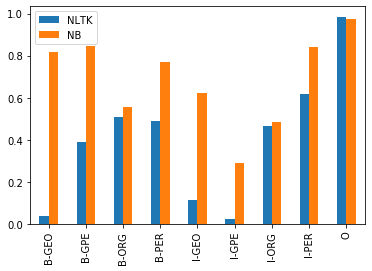

In [0]:
df = pd.DataFrame(np.c_[nltk_scores,nb_scores], index=targets, columns=['NLTK','NB'])
df.plot.bar()

plt.show()

As we can see the NB classfier achieved much higher scores for almost every category

While the results might give the impression that NLTK is much worse than our classifier, we should remeber that the NER tagging is not arbitrary, and interpretation of certain entities relies havily on traning data. And since we are testing on data similar to training set of our classfier, it has a great advantage over NLTK.

We can show the problem with a simple example:

In [13]:
nb_predict("President Trump is visiting Poland",model)

['B-PER', 'I-PER', 'O', 'O', 'B-GEO']

In [0]:
from_nltk_categories(nltk_predict("President Trump is visiting Poland"))

array(['O', 'B-PER', 'O', 'O', 'B-GPE'], dtype='<U8')

Since there is no strict definition of a named entity both classifications can be seen as correct - NLTK pays attention only to the surname, while our NB classfier tags "President Trump" as a single two-word entity.

Which one will be marked as correct depends solely on the test dataset.

##Validating full model on an independent dataset
The previous test have shown that NB classfier can perform better than NLTK for the test set derived from the same dataset as the training data, while also showing that the results may be significantly biased.

But now let's see how will they perform on an independent dataset. This time we will use all three classifiers.

We will use a [WikiNER dataset](https://github.com/dice-group/FOX/tree/master/input/Wikiner)

Unfortunately after running tests on the dataset and viewing some tagged entities, it seems that the categories and entity interpretation used in WikiNER don't match the ones used in NLTK and NB classfiers, which leads to terrible results for both of them.

Instead we will just focus on recognising **if** the word should be tagged as entity.

So this time there will be only two categories:
- ENT - the word should be tagged
- O - it should not

So both the training data and classifiers output will be converted to this "binary" model.

Once again the format of data is not very convenient for our classifiers to work with:


In [0]:
with open('aij-wikiner-en-wp3_10000','r+') as file:
  print(file.readline())

The|DT|I-MISC Oxford|NNP|I-MISC Companion|NNP|I-MISC to|TO|I-MISC Philosophy|NNP|I-MISC says|VBZ|O ,|,|O "|LQU|O there|EX|O is|VBZ|O no|DT|O single|JJ|O defining|VBG|O position|NN|O that|IN|O all|DT|O anarchists|NNS|O hold|VBP|O ,|,|O and|CC|O those|DT|O considered|VBN|O anarchists|NNS|O at|IN|O best|JJS|O share|NN|O a|DT|O certain|JJ|O family|NN|O resemblance|NN|O .|.|O "|RQU|O



So we have to convert it and reduce the number of categories to 2:

In [0]:
wikiner_df.head(5)

,sentence,tags
0,"The Oxford Companion to Philosophy says , "" th...",ENT ENT ENT ENT ENT O O O O O O O O O O O O O ...
1,"In the end , for anarchist historian Daniel Gu...",O O O O O O O ENT ENT O O O O O O O O O O O O ...
2,From this climate William Godwin developed wha...,O O O ENT ENT O O O O O O O O O O O O
3,"Godwin was , according to Peter Kropotkin , "" ...",ENT O O O O ENT ENT O O O O O O O O O O O O O ...
4,The first to describe himself as an anarchist ...,O O O O O O O O O ENT ENT O O ENT O O O O O O ...




The results for all three classifiers are following:

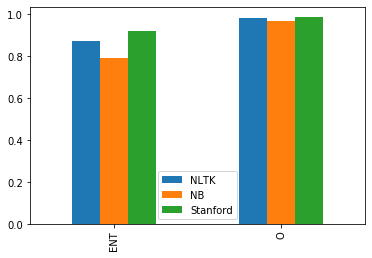

In [0]:
df = pd.DataFrame(np.c_[nltk_scores,nb_scores,st_scores], index=targets, columns=['NLTK','NB','Stanford'])
df.plot.bar()

plt.show()

In this case the results ale less favourable for our NB classfier.

But all of them seem to behave in similar way. While they slightly differ within ENT category, we can see that score for 'O' is above 90% in all cases.
The scores for ENT are also relatively high.
It means that each of them can with high probability say if a word is a named entity or if it isn't.

Stanford NER reached the highest score, but it's worth noting that when NB and NLTK were able to tag 10000 sentences in less than a minute, Stanford tagger needed more than **5 hours** to perform this task.



#Conclusions

It has been shown that a NER classfier based on a "simple" Naive Bayes algorithm can achieve results comparable to other classifiers.

Once again the NB proved itself to be a reliable classfier with many applications in NLP field, despite being based on "naive" assumptions.

#Further development

The classifier created above can be upgraded, using more careful data analysis.

Using more information such as part of speech of surrounding words, longer n-grams or lemmatization of words might have a positive impact on results.

#Code

##Imports

In [1]:
!pip install nltk

In [2]:
# Standard IPython notebook imports
%matplotlib inline

import os

import httpimport
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import scipy.stats as sstats

import seaborn as sns
from sklearn import datasets
import csv as csv
import sklearn.decomposition
import sklearn.svm
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
import json
from nltk.tag import StanfordNERTagger

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping chunkers/maxent_ne_chunker.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


###Preparing data

In [0]:
full_df = pd.read_csv("ner_dataset.csv",encoding = "ISO-8859-1")

In [0]:
full_df = full_df.fillna(method='ffill')
full_df['Tag'] = np.char.upper(list(full_df['Tag']))
full_df['Tag'][np.isin(full_df['Tag'],['B-ART','B-EVE','B-NAT'])] = 'O'
full_df['Tag'][np.isin(full_df['Tag'],['I-ART','I-EVE','I-NAT'])] = 'O'
full_df['Tag'][np.isin(full_df['Tag'],['I-TIM','B-TIM'])] = 'O'

In [0]:
def create_sentences(sentence_df, full_df):  
  index =0
  prev = None
  sentence =[]
  pos = []
  tags = [] 
  for i in range(len(full_df)):
    row = full_df.iloc[i]
    s_num = row[0]
    word = row[1]
    ps = row[2]
    ner = row[3]
    if i>0 and prev!=s_num:
      sentence_df.loc[index] = (" ".join(sentence)," ".join(pos)," ".join(tags))
      index+=1
      sentence =[]
      pos = []
      tags = [] 
    
    sentence.append(word)
    pos.append(ps)
    tags.append(ner)
    prev = s_num

In [0]:
sentence_df = pd.DataFrame(columns=['sentence', 'pos', 'tags'])
create_sentences(sentence_df, full_df)

In [0]:
sentence_df.to_csv(r'corpus_4_categories.csv')

##Creating Naive Bayes model from data

In [0]:
def put_in_dict(key,dct,target, targets):
  dct.setdefault(key, np.ones(len(targets))*0.5)
  dct[key]+=(targets==target)

In [0]:
def normalize_dictionary(dct,target_counts):
  vls = np.array(list(dct.values()))
  vls/target_counts
  vls = vls/np.sum(vls,axis=0)
  vls = np.log(vls+1E-100)
  return dict(zip(dct.keys(), vls.tolist()))

In [0]:
def create_model(sentence_df, save_path):
  targets, target_counts = np.unique(np.hstack(np.chararray.split(np.array(sentence_df['tags'],\
                                                                           dtype='str'))),\
                                     return_counts=True)
  target_counts = target_counts/(len(target_counts))
  word_dict={}
  pos_dict={}
  prev_dict={}
  next_dict={}
  is_title={}
  for index,row in sentence_df.iterrows():
    words = row[1].split()
    pos = row[2].split()
    tags = row[3].split()
    if len(tags)!=len(words):
        continue
    for i in range(len(words)):
      put_in_dict(words[i].lower(),word_dict,tags[i],targets)
      put_in_dict(pos[i],pos_dict,tags[i],targets)
      put_in_dict(words[i].istitle(),is_title,tags[i],targets)
      if i==0:
        put_in_dict('$$$NONE$$$',prev_dict,tags[i],targets)
      else:
        put_in_dict(words[i-1].lower(),prev_dict,tags[i],targets)
      if i==len(words)-1:
        put_in_dict('$$$NONE$$$',next_dict,tags[i],targets)
      else:
        put_in_dict(words[i+1].lower(),next_dict,tags[i],targets)
  
  json_dict = {}
  json_dict['words'] = normalize_dictionary(word_dict,target_counts)
  json_dict['pos'] = normalize_dictionary(pos_dict,target_counts)
  json_dict['prev'] = normalize_dictionary(prev_dict,target_counts)
  json_dict['next'] = normalize_dictionary(next_dict,target_counts)
  json_dict['title'] = normalize_dictionary(is_title,target_counts)
  json_dict['targets'] = targets.tolist()
  with open(save_path, 'w') as fout:
    json.dump(json_dict , fout)

##Naive Bayes classfier

In [0]:
def naive_bayes(elem, model):
  dicts = list(model.values())[:-1]
  targets =  list(model.values())[-1:][0]
  log_probs=np.zeros(len(targets))
  for i in range(len(elem)):
    dct = dicts[i]
    log_probs+=np.array(dct.get(elem[i],np.ones(len(targets))*-0.69314718056))
  exps = np.exp(log_probs)
  return targets[np.argmax(exps)]

##Creating models

##Train-test model


In [0]:
sentence_df = pd.read_csv('corpus_4_categories.csv')

In [0]:
train_df = sentence_df.head(np.int(len(sentence_df)*0.8))
test_df = sentence_df.tail(len(sentence_df)-len(train_df))

In [0]:
create_model(train_df,"4_categories_train_model.json")

##Full model

In [0]:
create_model(sentence_df,"4_categories_full_model.json")

##Validation and comparing results to other classifiers

###Utilities

In [0]:
def read_model(path):
  with open(path, 'r') as f:
    model = json.load(f)
  return model

In [0]:
def from_nltk_categories(nltk_preds):
  nltk_preds = np.array(nltk_preds)
  nltk_preds[nltk_preds=='B-FACILITY'] = 'O'
  nltk_preds[nltk_preds=='I-FACILITY'] = 'O'
  nltk_preds[nltk_preds=='B-GSP'] = 'B-GPE'
  nltk_preds[nltk_preds=='I-GSP'] = 'I-GPE'
  nltk_preds[nltk_preds=='B-LOCATION'] = 'B-GEO'
  nltk_preds[nltk_preds=='I-LOCATION'] = 'I-GEO'
  nltk_preds[nltk_preds=='B-ORGANIZATION'] = 'B-ORG'
  nltk_preds[nltk_preds=='I-ORGANIZATION'] = 'I-ORG'
  nltk_preds[nltk_preds=='B-PERSON'] = 'B-PER'
  nltk_preds[nltk_preds=='I-PERSON'] = 'I-PER'
  return nltk_preds

###Validating the train-test model

In this case we will use only our NB classifier and NLTK, because categories in Stanford models don't match the ones used in our dataset.

####Calculating predictions

In [0]:
model = read_model("4_categories_train_model.json")

In [0]:
nb_preds = []
nb_actual = []
for index, row in test_df.iterrows():
  words = row[1].split()
  pos = row[2].split()
  tags = row[3].split()
  if len(tags)!=len(words):
    continue
  for i in range(len(words)):
    if i==0:
      prev = '$$$NONE$$$'
    else:
      prev = words[i-1].lower()
    if i==len(words)-1:
      nxt = '$$$NONE$$$'
    else:
      nxt= words[i+1].lower()
    element = (words[i].lower(),pos[i],prev,nxt,words[i].istitle())
    nb_preds.append(naive_bayes(element,model))
    nb_actual.append(tags[i])

In [0]:
nltk_preds = []
nltk_actual = []
for index, row in test_df.iterrows():
  words = row[1]
  tags = row[3].split()
  tokens = nltk.word_tokenize(words)
  if(len(tags)!=len(tokens)):
    continue
  tagged_words = nltk.pos_tag(nltk.word_tokenize(words))
  nltk_unformatted_prediction = nltk.ne_chunk(tagged_words)
  multiline_string = nltk.chunk.tree2conllstr(nltk_unformatted_prediction)
  listed_pos_and_ne = multiline_string.split()
  nltk_preds.extend(listed_pos_and_ne[2::3])
  nltk_actual.extend(tags)
nltk_preds = from_nltk_categories(nltk_preds)

####Comparing results

We will now compare the F1 scores of both classfiers. 

In [0]:
from sklearn.metrics import classification_report
nltk_rep = classification_report(nltk_actual, nltk_preds,target_names=list(model.values())[-1:][0], output_dict=True)
nb_rep = classification_report(nb_actual, nb_preds,target_names=list(model.values())[-1:][0], output_dict=True)

In [0]:
targets = list(model.values())[-1:][0]
nltk_scores = []
for scores in list(nltk_rep.values())[:9]:
  nltk_scores.append(scores['f1-score'])
nb_scores = []
for scores in list(nb_rep.values())[:9]:
  nb_scores.append(scores['f1-score'])

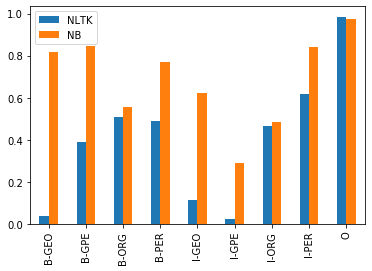

In [0]:
df = pd.DataFrame(np.c_[nltk_scores,nb_scores], index=targets, columns=['NLTK','NB'])
df.plot.bar()

plt.show()

###Validating full model on an independent dataset

####Preprocessing 

The data need some preprocessing as the format is not very convenient for both classfiers

In [0]:
wikiner_df = pd.DataFrame(columns=['sentence', 'tags'])
index = 0
with open('aij-wikiner-en-wp3_10000','r') as file:
  for line in file:
    tokens = line.split()
    sentence = []
    tags = []
    for t in tokens:
      t = t.split("|")
      sentence.append(t[0])
      if t[2] != 'O':
        tags.append('ENT')
      else:
        tags.append(t[2])
    wikiner_df.loc[index] = (" ".join(sentence)," ".join(tags))
    index+=1

We will need to convert our predictions to "binary" categories

In [0]:
def convert_categories(preds):
  preds = np.array(preds)
  preds[preds!='O'] = 'ENT'
  return preds

####Calculating predictions

In [0]:
def nb_predict(sent, model):
  tokens = nltk.pos_tag(nltk.word_tokenize(sent))
  preds = []
  for i in range(len(tokens)):
    word = tokens[i][0].lower()
    pos = tokens[i][1].strip('$')
    is_title = str(word.istitle()).lower()
    if i==0:
      prev = '$$$NONE$$$'
    else:
      prev = tokens[i-1][0].lower()
    if i==len(tokens)-1:
      nxt = '$$$NONE$$$'
    else:
      nxt = tokens[i+1][0].lower()
    elem = (word,pos,prev,nxt,is_title)
    pred = naive_bayes(elem, model)
    preds.append(pred)
  return preds

In [0]:
model = read_model("4_categories_full_model.json")
nb_preds = []
nb_actual = []

for index, row in wikiner_df.iterrows():
  words = row[0]
  tags = row[1].split()
  preds = nb_predict(words,model)
  if(len(preds)!=len(tags)):
    continue
  nb_preds.extend(preds)
  nb_actual.extend(tags)
nb_preds = convert_categories(nb_preds)

In [0]:
def nltk_predict(words):
  tagged_words = nltk.pos_tag(nltk.word_tokenize(words))
  nltk_unformatted_prediction = nltk.ne_chunk(tagged_words)
  multiline_string = nltk.chunk.tree2conllstr(nltk_unformatted_prediction)
  listed_pos_and_ne = multiline_string.split()
  return listed_pos_and_ne[2::3]

In [0]:
nltk_preds = []
nltk_actual = []
for index, row in wikiner_df.iterrows():
  words = row[0]
  tags = row[1].split()
  tokens = nltk.word_tokenize(words)
  if(len(tags)!=len(tokens)):
    continue
  nltk_preds.extend(nltk_predict(words))
  nltk_actual.extend(tags)
nltk_preds = convert_categories(nltk_preds)

In [0]:
st_preds = []
st_actual = []
st = StanfordNERTagger('english.conll.4class.distsim.crf.ser.gz','stanford-ner.jar',encoding='utf-8')
for index, row in wikiner_df.iterrows():
  words = row[0]
  tags = row[1].split()
  tokens = nltk.word_tokenize(words)
  if(len(tags)!=len(tokens)) or len(tags)==0:
    continue
  tagged_words = st.tag(tokens) 
  st_preds.extend(np.array(tagged_words)[:,1].tolist())
  st_actual.extend(tags)
st_preds = convert_categories(st_preds)

####Comparing results

In [0]:
from sklearn.metrics import classification_report
targets = np.unique(nltk_actual)
nltk_rep = classification_report(nltk_preds, nltk_actual,target_names=targets, output_dict=True)
nb_rep = classification_report(nb_preds, nb_actual,target_names=targets, output_dict=True)
st_rep = classification_report(st_preds, st_actual,target_names=targets, output_dict=True)

In [0]:
nltk_scores = []
for scores in list(nltk_rep.values())[:2]:
  nltk_scores.append(scores['f1-score'])
nb_scores = []
for scores in list(nb_rep.values())[:2]:
  nb_scores.append(scores['f1-score'])
st_scores = []
for scores in list(st_rep.values())[:2]:
  st_scores.append(scores['f1-score'])

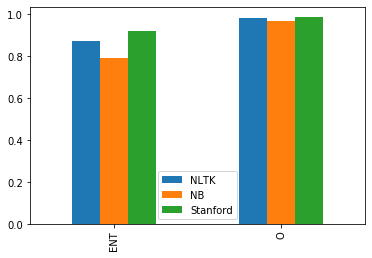

In [0]:
df = pd.DataFrame(np.c_[nltk_scores,nb_scores,st_scores], index=targets, columns=['NLTK','NB','Stanford'])
df.plot.bar()

plt.show()